# Kaggle BCI Challenge @NER 2015

**Author**:
Yundong Wang

## Introduction

This project applied machine learning techniques to the P300 speller classification challenge at Kaggle BCI Challenge @ NER 2015. The P300 speller is a brain-computer interface paradigm that allows one to input text or commands to a computer via brain activity measured by electroencephalography (EEG).

xDAWN “Covariance algorithm and Tangent Space algorithm” which uses the spatial correlations of the simultaneously recorded EEG as features for the error detection classification are implemented.

We applied multiple machine learning techniques (SVM, Logistic Regression, Random Forest, etc) and deep learning model dedicated for EEG data ([EEGNET](https://arxiv.org/pdf/1611.08024.pdf)). Lastly, we built a StackNet model that achieved the 4th best AUC (0.803) result compared to the candidates pool.

The presentation slides can be found [here.](https://docs.google.com/presentation/d/16Orsav1K4bPTFhPx3TsfYNxzgrvTMb2Gcf9RTC6WYmU/edit?ts=5c8aa323#slide=id.g5231037314_0_0)

![video](images2/p300.gif)


# Dataset
Each session include 60 target stimulus, however, the last session of each subject contains 100 target stimulus. Which makes 340 target stimulus for each subject

Data is collected at 200 Hz across 26 subjects (16 for training, 10 for testing). Each subject participated in 5 different sessions.

0 or 1 for bad or good feedback, respectively. Bad feedback is when the selected item is different from the expected item. Good feedback is when the selected item is similar to the expected item.

The Kaggle description and dataset can be downloaded [here.](https://www.kaggle.com/c/inria-bci-challenge)

## Section 1: Setup

- To run python code, please download data from https://www.kaggle.com/c/inria-bci-challenge/data and put *train* and *test* directories under *data*. **Python version: 3.6+**

- To run *preprocess.py*, install **pyriemann** packages using pip.

- To run *EEGNET.py*, install EEGModels at https://github.com/vlawhern/arl-eegmodels and required **TensorFlow** packages.

- To run *StackNet.py*, install **pystacknet** at https://github.com/h2oai/pystacknet, install **LightGBM** and **XGBoost** using conda or pip.

Before we can begin processing our data, we must first import some useful packages. <br>
- **numpy** is used widely for processing numerical data, and supports matrix operations natively. We will be using NumPy arrays to store our data.
- **scipy** contains useful functions to calculate filter coefficients and carry out filtering. We will be using SciPy filters to clean our EEG data.
- **matplotlib** is used to create plots. We will use it to visually explore our filter and EEG data.
- **sklearn** used for machine learning. We will use this to train our classifier and make predictions

In [1]:
import numpy as np                                      # for dealing with data
from scipy.signal import butter, sosfiltfilt, sosfreqz  # for filtering
import matplotlib.pyplot as plt                         # for plotting
from scipy import interp
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
import os
from os import listdir
from os.path import isfile, join, isdir
import pickle

## Section 2: Pre-processing

**Step 1: Design a filter**<br>

- Filter.......: Butterworth, noncausal filtfilt
- Order......: 5nd
- High pass: 1 Hz
- Low pass.: 40 Hz

In [2]:
# Create filtering variables
fs = 200.0     # 200 Hz sampling rate
lowcut = 1.0   # 0.1 Hz is the lowest frequency we will pass
highcut = 40.0 # 40 Hz is the highest frequency we will pass.

In [3]:
def butter_bandpass_filter(raw_data, fs, lowcut = 1.0, highcut =40.0, order = 5):
    '''
    The filter I want to apply to my raw eeg data.
    :raw_data (nparray): data you want to process
    :fs (float): sampling rate
    :lowcut (float, optional): lowest frequency we will pass
    :highcut (float, optional): highest frequency we will pass
    :order (int, optional): order of filter
    '''
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    sos = butter(order, [low, high], analog = False, btype = 'band', output = 'sos')
    filted_data = sosfiltfilt(sos, raw_data)
    return filted_data

**Step 2: Determine our epoch, baseline, and window of focus**<br>

- Epoch...: 0 ~ 700ms
- Baseline: 0 ~ 100ms 

The following is a visual explanation of the baseline, ERP window selection, and sub-sampling routine (on a single channel, using the figure provided by Alessandro D'Amico):
<img src="images2/img1.png">


In [4]:
epoch_s = 0      # epoch starting time relative to stmulus in miliseconds
epoch_e = 700    # epoch ending time relative to stmulus in miliseconds
bl_s = 0         # baseline starting time relative to stmulus in miliseconds
bl_e = 100       # baseline ending time relative to stmulus in miliseconds


# number of mark per epoch
epoch_len = int((abs(epoch_s) + abs(epoch_e)) * (fs / 1000)) 


**Step 3: Understand our data**<br>

- 16 participants in the training dataset.
- 10 participants in the testing dataset.
- 5 trials per participant
- 60 stimulus per trial in the first 4 trials, and 100 stimulus per trial in the last trial.
- Thus, 340 stimulus per trial.
- 56 channel EEG data


In [5]:
train_subj_num = 16
test_subj_num = 10
stimulus_per_subj = 340
trial_per_subj = 5

channels = ['Fp1', 'Fp2', 'AF7', 'AF3', 'AF4', 'AF8', 'F7', 'F5', 'F3', 'F1',
    'Fz', 'F2', 'F4', 'F6', 'F8', 'FT7', 'FC5', 'FC3', 'FC1', 'FCz',
    'FC2', 'FC4', 'FC6', 'FT8', 'T7', 'C5', 'C3', 'C1', 'Cz', 'C2',
    'C4', 'C6', 'T8', 'TP7', 'CP5', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4',
    'CP6', 'TP8', 'P7', 'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'P8',
    'PO7', 'POz', 'P08', 'O1', 'O2']

In [6]:
import pandas as pd
train_labels = pd.read_csv("./data/TrainLabels.csv")
sample_train_data = pd.read_csv("./data/train/Data_S02_Sess01.csv")

In [7]:
train_labels

,IdFeedBack,Prediction
0,S02_Sess01_FB001,1
1,S02_Sess01_FB002,1
2,S02_Sess01_FB003,0
3,S02_Sess01_FB004,0
4,S02_Sess01_FB005,1
...,...,...
5435,S26_Sess05_FB096,1
5436,S26_Sess05_FB097,0
5437,S26_Sess05_FB098,0
5438,S26_Sess05_FB099,0


In [8]:
sample_train_data

,Time,Fp1,Fp2,AF7,AF3,AF4,AF8,F7,F5,F3,...,P4,P6,P8,PO7,POz,P08,O1,O2,EOG,FeedBackEvent
0,0.000,509.630351,609.688545,522.032153,454.102593,309.486489,524.804335,484.333383,587.340998,469.651564,...,295.834834,485.530586,411.161892,448.726097,99.151239,613.529369,428.286969,378.933590,-906.668876,0
1,0.005,864.521388,1038.483761,917.023604,775.970207,576.123392,934.962455,833.427809,996.070640,823.715523,...,528.713692,894.541770,735.827300,780.487458,239.407648,1067.349342,782.319229,711.286079,-1484.107119,0
2,0.010,754.576625,904.117869,803.235608,678.039830,489.573235,803.064230,706.392172,868.996293,717.565698,...,459.066586,870.217213,691.971456,689.656321,255.876323,933.617965,679.366071,699.014004,-1313.435186,0
3,0.015,801.593761,957.870867,834.026569,716.254450,519.006819,860.058239,769.518284,921.777695,756.664761,...,487.899954,905.564172,723.595463,723.944898,247.990115,992.180045,713.405603,714.734949,-1391.966973,0
4,0.020,769.054899,920.060832,811.596932,692.750986,494.315305,817.206918,727.500302,892.004312,729.239924,...,464.032652,769.258159,642.962959,687.852792,179.835749,949.832471,680.906506,607.057329,-1347.494166,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131996,659.980,326.493877,148.619853,367.120885,329.607132,568.760051,228.081535,386.342230,193.539354,263.262863,...,497.935681,136.897186,194.816484,235.516599,698.470304,115.904670,346.770258,-22.426859,-1179.103975,0
131997,659.985,299.398029,122.348935,317.862613,299.081994,540.210149,183.619873,354.533814,148.285289,208.522216,...,483.786225,87.994431,158.168639,220.717339,681.475238,69.722673,304.952629,-71.490262,-1245.844338,0
131998,659.990,313.987327,143.185940,352.162704,321.971403,551.396419,219.448645,345.700353,196.750843,253.721728,...,482.381296,130.181271,228.417928,229.943069,718.838360,110.441383,325.000921,62.368775,-1150.955909,0
131999,659.995,308.194641,121.836127,323.251844,313.754887,575.047001,202.242791,358.987420,165.629556,231.005230,...,511.892613,103.343795,229.027509,233.729526,782.742133,85.836597,327.645835,38.482607,-1304.594442,0


**Step 4: Create placeholder for loading our data**<br>
- There are 16 training participants, 5 trials per participant.
- There are 10 test participants, 5 trials per participant.
- There are 340 trials per participant, 56 channels for each trial, and our epoch length is 260.


In [9]:
train_list_arr = np.array(sorted(listdir('./data/train')))
train_list_np = np.reshape(
    train_list_arr, (train_subj_num, trial_per_subj))
test_list_arr = np.array(sorted(listdir('./data/test')))
test_list_np = np.reshape(
    test_list_arr, (test_subj_num, trial_per_subj))
print(train_list_np.shape, test_list_np.shape)

train_data_list = np.empty(
    (0, stimulus_per_subj, len(channels), epoch_len), float)
test_data_list = np.empty(
    (0, stimulus_per_subj, len(channels), epoch_len), float)
print(train_data_list.shape, test_data_list.shape)

(16, 5) (10, 5)
(0, 340, 56, 140) (0, 340, 56, 140)


**Step 5: Define our epoch function**<br>
We apply this function to each EEG trial.

In [10]:
def generate_epoch(file_path, channels, fs, eeg_filter, stimulus_times=None, baseline=True,  epoch_s=0, epoch_e=700, bl_s=0, bl_e=100):
    """
    :description: Generating epoch given csv file. Make sure the csv file layout meets the requirement.
        It should contain 'Time' column that represents timepoints, and the time should start from 0.
        If your csv file does not have FeedBackEvent indicating the stimulus, you must pass stumulus_times.
        Here we used a butter bandpass filter, but you can change to your favorite one.

    :file_path (String): path to your csv file
    :channels ([String]): array of channels to epoch
    :fs (float): sampling rate
    :eeg_filter (function): the filter you want to apply to raw eeg data
    :stimulus_times ([float], optional): The time points that stimulus occur
    :baseline (boolean, optional): whether you want to apply baseline correction after epoching
    :epoch_s (int, optional): epoch starting time relative to stmulus in miliseconds
    :epoch_e (int, optional): epoch ending time relative to stmulus in miliseconds
    :bl_s (int, optional): baseline starting time relative to stmulus in miliseconds
    :bl_e (int, optional): baseline ending time relative to stmulus in miliseconds

    :rtype (3d-nparray): epoched data with dimension (stimulus_per_trial, number_of_channels, number_of_time_points)
    """
    # read data and data selection
    train_data = pd.read_csv(file_path)

    train_data.loc[:, 'Time'] = train_data.loc[:, 'Time']*1000
    raw_eeg = train_data[channels].values.T

    time_df = train_data['Time'].values
    train_data['index'] = train_data.index.values
    if stimulus_times is None:
        mark_indices = np.asarray(
            train_data[train_data['FeedBackEvent'] == 1].index).flatten()
    else:
        mark_indices = np.round(np.asarray(
            stimulus_times).flatten() * fs).astype(int)

    # Define the bounds of our epoch as well as our baseline
    # index in epoch_df where our baseline begins
    b_s = int((abs(epoch_s) + bl_s) * (fs / 1000))
    # index in epoch_df where our baseline ends
    b_e = int((abs(epoch_s) + bl_e) * (fs / 1000))
    # Let's calculate the length our epoch with our given sampling rate
    epoch_len = int((abs(epoch_s) + abs(epoch_e)) * (fs / 1000))

    # Let's define some helpful variables to make our extraction easier
    # effectively the number of indices before marker we want
    e_s = int((epoch_s * (fs / 1000)))
    # effectively the number of indices after marker we want
    e_e = int((epoch_e * (fs / 1000)))

    # Epoch the data
    final_epoch = np.empty((mark_indices.shape[0], epoch_len, 0), float)
    for channel in channels:
        epoch = np.zeros(shape=(int(mark_indices.shape[0]), epoch_len))
        raw_eeg = train_data[channel].values

        ################# You may want to apply your own filter ################
        clean_eeg = eeg_filter(raw_eeg, fs, lowcut, highcut, 5)
        ########################################################################

        for i, mark_idx in enumerate(mark_indices):
            # grab the appropriate samples around the stimulus onset
            epoch[i, :] = clean_eeg[mark_idx + e_s: mark_idx + e_e]

        # Baseline correction
        if baseline:
            for i in range(0, int(epoch.shape[0])):
                epoch[i, :] = epoch[i, :] - np.mean(epoch[i, b_s:b_e])

        # stack epoch of each channel
        final_epoch = np.dstack((final_epoch, epoch))
    final_epoch = np.swapaxes(final_epoch, 1, 2)
    return final_epoch

**Step 6: Epoch all data using epoch function we wrote**<br>
Now we have generated trainable data that can be fed into models. Skip this if we have already saved them in the first run.

In [11]:
if not isfile("./data/train_data.npy"):
    for training_participant_id in range(train_subj_num):
        subject_dir_list = train_list_np[training_participant_id]
        subject_epoch = np.empty((0, len(channels), epoch_len), float)
        for trial_id in range(trial_per_subj):
            subject_dir = subject_dir_list[trial_id]
            data = generate_epoch('./data/train/'+subject_dir, channels, fs,
                butter_bandpass_filter, epoch_s = epoch_s, epoch_e = epoch_e, bl_s = bl_s, bl_e = bl_e)
            subject_epoch = np.vstack((subject_epoch, data))
        subject_epoch = np.reshape(
            subject_epoch, (1, stimulus_per_subj, len(channels), epoch_len))
        train_data_list = np.vstack((train_data_list, subject_epoch))

    print('Epoched training data shape: ' + str(train_data_list.shape))

    for testing_participant_id in range(test_subj_num):
        subject_dir_list = test_list_np[testing_participant_id]
        subject_epoch = np.empty((0, len(channels), epoch_len), float)
        for trial_id in range(trial_per_subj):
            subject_dir = subject_dir_list[trial_id]
            data = generate_epoch('./data/test/'+subject_dir, channels, fs,
                butter_bandpass_filter, epoch_s = epoch_s, epoch_e = epoch_e, bl_s = bl_s, bl_e = bl_e)
            subject_epoch = np.vstack((subject_epoch, data))
        subject_epoch = np.reshape(
            subject_epoch, (1, stimulus_per_subj, len(channels), epoch_len))
        test_data_list = np.vstack((test_data_list, subject_epoch))

    print('Epoched testing data shape: ' + str(test_data_list.shape))

    np.save('./data/train_data.npy', train_data_list)
    np.save('./data/test_data.npy', test_data_list)

In [12]:
train_data_list = np.load('./data/train_data.npy')
test_data_list = np.load('./data/test_data.npy')
print('Epoched training data shape: ' + str(train_data_list.shape))
print('Epoched testing data shape: ' + str(test_data_list.shape))


Epoched training data shape: (16, 340, 56, 140)
Epoched testing data shape: (10, 340, 56, 140)


#### Samples of Epoched EEG data
<table>
    <tbody>
        <tr>
            <td>
                <img src="./images2/Subject_2_Fz.png"/>
            </td>
            <td>
                <img src="./images2/Subject_2_Pz.png"/>
            </td>
        </tr>
        <tr>
            <td>
                <img src="./images2/Fz.png"/>
            </td>
            <td>
                <img src="./images2/Pz.png"/>
            </td>
        </tr>
    </tbody>
</table>

**Step 7: Apply xDawn Covariance algorithm and Tangent Space algorithm**<br>
After epoching our data, our data is in (subject, trial, channel, stimulus). Last two dimensions correspond to **spatial** and **temporal** dimensions.

Therefore, further feature exctraction and dimensionality reduction is necessary for standard machine learning algorithm to work.

In [13]:
from pyriemann.estimation import XdawnCovariances
from pyriemann.tangentspace import TangentSpace

In [14]:
Y_train = pd.read_csv('data/TrainLabels.csv')['Prediction'].values

In [15]:
if not isfile('./data/X_train.npy'):
    XC = XdawnCovariances(nfilter=5) # our transformer
    TS = TangentSpace(metric='riemann')
    # collapse first two dimension
    train_data = np.reshape(train_data_list, 
    (train_subj_num * stimulus_per_subj, len(channels), epoch_len))
    test_data = np.reshape(test_data_list, 
    (test_subj_num * stimulus_per_subj, len(channels), epoch_len))

    # transform our data
    X_train = XC.fit_transform(train_data, Y_train)
    X_train = TS.fit_transform(X_train)
    X_test = XC.transform(test_data)
    X_test = TS.transform(X_test)

    # save to local
    np.save('./data/X_train', X_train)
    np.save('./data/X_test', X_test)
    np.save('./data/Y_train', Y_train)

## Section 4: Cross Validation and Classification with Machine Learning 

**Step 1: Load our data**<br>


In [16]:
# Load our data
X_train = np.load('./data/X_train.npy')
X_test = np.load('./data/X_test.npy')
Y_train = np.load('./data/Y_train.npy')

# Only used for scoring
Y_test = np.reshape(pd.read_csv('./data/true_labels.csv', header=None).values, 3400)


In [17]:
print('Transformed training data shape: ' + str(X_train.shape))
print('Training label shape: ' + str(Y_train.shape))
print('Transformed testing data shape: ' + str(X_test.shape))
print('Testing label shape: ' + str(Y_test.shape))


Transformed training data shape: (5440, 210)
Training label shape: (5440,)
Transformed testing data shape: (3400, 210)
Testing label shape: (3400,)


**Step 2a: Use RandomForest for prediction**<br>


In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'n_estimators': [100, 200, 300, 1000]
}

# Fit the grid search to the data
if not isfile('random_forest_gs'): 
    rf = RandomForestClassifier()
    # Instantiate the grid search model
    grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
               cv = 4, n_jobs = -1)
    grid_search.fit(X_train, Y_train)
    pickle.dump(grid_search, open('random_forest_gs', 'wb'))

In [19]:
grid_search = pickle.load(open('random_forest_gs', 'rb'))
print(grid_search.best_params_)

{'bootstrap': True, 'max_depth': 80, 'max_features': 3, 'n_estimators': 200}


**Step 3a: Evaluate the performance of RandomForest**<br>


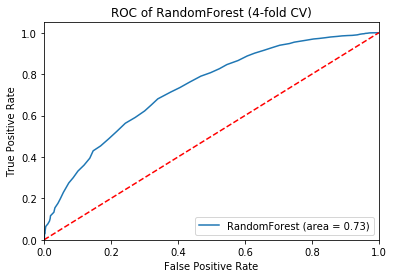

In [20]:
from sklearn.metrics import roc_auc_score, roc_curve

# Predict the probability of our label score
Y_pred_proba = grid_search.predict_proba(X_test)

r_roc_auc = roc_auc_score(Y_test, Y_pred_proba[:,1])
fpr, tpr, thresholds = roc_curve(Y_test, Y_pred_proba[:,1])
plt.figure()
plt.plot(fpr, tpr, label='RandomForest (area = %0.2f)' % r_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC of RandomForest (4-fold CV)')
plt.legend(loc="lower right")
plt.savefig('images2/Randomforest_ROC')
plt.show()

**Extra: StackNet**<br>
The following is a visual explanation of the baseline, ERP window selection, and sub-sampling routine (on a single channel, using the figure provided by Alessandro D'Amico):
<img src="images2/StackNet.png">

In [21]:
from pystacknet.pystacknet import StackNetClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import KFold
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.neural_network import MLPClassifier, MLPRegressor

/opt/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the followin

In [22]:
models = [
    #1ST layer #
    [GridSearchCV(LDA(solver='lsqr'),  {'shrinkage': (0.01, 0.1, 1.)}, cv=3, n_jobs=-1),
     GridSearchCV(SVC(class_weight='balanced', probability=True),  {'kernel': [
                  'rbf'], 'gamma': [10**(-2), 10**(-3)], 'C': [100, 10, 1, 0.1]}, cv=3, n_jobs=-1),
     GridSearchCV(LogisticRegression(class_weight='balanced',
                                     solver='lbfgs', max_iter=100000), {'C': [100, 10, 1, 0.1]}, cv=3, n_jobs=-1),
     LGBMClassifier(boosting_type='gbdt', num_leaves=40, max_depth=-1, learning_rate=0.01, n_estimators=1000, class_weight='balanced', subsample_for_bin=1000, objective="xentropy",
                    min_split_gain=0.0, min_child_weight=0.01, min_child_samples=10, subsample=0.9, subsample_freq=1, colsample_bytree=0.5, reg_alpha=0.0, reg_lambda=0.0, random_state=1, n_jobs=1),
     GaussianProcessClassifier(),
     XGBClassifier(max_depth=5, learning_rate=0.3, reg_lambda=0.1, n_estimators=300,
                   objective="binary:logistic", n_jobs=1, booster="gblinear", random_state=1, colsample_bytree=0.4),
     XGBClassifier(max_depth=20, learning_rate=0.1, n_estimators=300, objective="binary:logistic",
                   n_jobs=1, booster="gbtree", random_state=1, colsample_bytree=0.4),
     XGBClassifier(max_depth=100, learning_rate=0.1, n_estimators=300, objective="rank:pairwise",
                   n_jobs=1, booster="gbtree", random_state=1, colsample_bytree=0.4),
     ],

    #2ND layer #
    [
        RandomForestClassifier(max_depth=50, n_estimators=50),
        AdaBoostClassifier(base_estimator=DecisionTreeClassifier(
            max_depth=5), n_estimators=200),
        ExtraTreesClassifier(max_depth=5, n_estimators=50),
    ],

    #3RD layer #
    [
        RandomForestClassifier(
            max_depth=5, class_weight='balanced', n_estimators=100),
        SVC(kernel='linear', class_weight='balanced', probability=True),
        MLPClassifier(hidden_layer_sizes=(32, 16), activation="relu", solver="sgd", alpha=0.01,
                      batch_size=30, learning_rate="adaptive", learning_rate_init=0.001, power_t=0.5,
                      max_iter=100, shuffle=True, random_state=1, tol=0.0001, nesterovs_momentum=True, momentum=0.9, validation_fraction=0.1, early_stopping=True,
                      beta_1=0.1, beta_2=0.1, epsilon=0.1)
    ]
]

In [23]:
# leave 4 subject out
kf = KFold(4)
generator = kf.split(X_train, Y_train)

# build StackNet
stacknet = StackNetClassifier(models, metric="auc", folds=generator, 
           restacking=False, use_retraining=True, use_proba=True,
           n_jobs=-1, verbose=1)

In [24]:
# make predictions
if not isfile('data/stacknet_prediction.npy'):
    stacknet.fit(X_train, Y_train)
    y_probs = stacknet.predict_proba(X_test)[:, 1]
    np.save('data/stacknet_prediction.npy', y_probs)

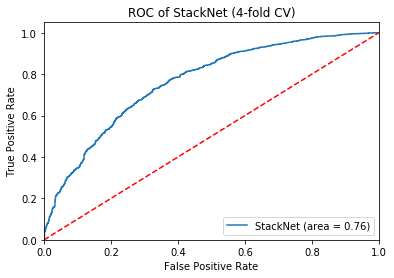

In [25]:
y_probs = np.load('data/stacknet_prediction.npy')
r_roc_auc = roc_auc_score(Y_test, y_probs)
fpr, tpr, thresholds = roc_curve(Y_test, y_probs)
plt.figure()
plt.plot(fpr, tpr, label='StackNet (area = %0.2f)' % r_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC of StackNet (4-fold CV)')
plt.legend(loc="lower right")
plt.savefig('images2/StackNet_ROC')
plt.show()